In [ ]:
import torch
import numpy as np  

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import utils_funcs as futil

In [2]:
torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=3)  # show 3 decimal places

In [3]:
save_fig = False
figsize1 = (4,3)
figsize2 = (4,5)
figsize3 = (4,8)
figsizeH = (9.5,5)

In [4]:
#model = 'exponential'
model = 'logistic'
#model = 'gompertz'
DIV_GOMP = 5.

# Carrying capacity as fold of initial cell density
K_N0 = torch.log(torch.tensor(1e3)) 

# number of variants
K = 100
# Experimental time points
times = torch.tensor([0, 3, 6, 12, 18], dtype=torch.float32)
T = len(times)

# Generate variant read counts

### Randomly select slope and intercept for the variants

In [5]:
# ---- Parameters ---- 
# grwoth rate
lambda0 = torch.tensor(0.05) # per hour

# ---- Plotting ----
if K < 11:
    colors = plt.cm.tab10(np.linspace(0, 1, K))
else:
    colors = plt.cm.tab20(np.linspace(0, 1, K))
    
#colors = sns.color_palette("Set1", K)
# Define a list of markers
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*', 'X']

seed = torch.seed()      # whatever PyTorch just pulled from /dev/urandom
seed = 18443758916587372700
print("Seed is:", seed)
torch.manual_seed(seed)

# ---- Random fitness and intercepts ----
# growth rates
selects = torch.sort(torch.normal(lambda0, 0.4, size=(K,)), descending=True).values
growth_rates_true = lambda0 + selects
# GOMPERTZ
if model == 'gompertz':
    growth_rates_true /= DIV_GOMP
# log abundance at time zero
log_abundances_true = torch.normal(0,0.9, size=(K,))
# normalize such that initial cell denisty is 1
shift = torch.logsumexp(log_abundances_true,dim=0)
log_abundances_true -= shift
#check
print("initial density relative to K:",torch.exp(log_abundances_true).sum().item())

print("          growth rates:", growth_rates_true)
print("initial log abundances:", log_abundances_true)
f_init = torch.softmax(log_abundances_true,dim=0)
print("initial fraction:", f_init)

params_true = [growth_rates_true,log_abundances_true]

Seed is: 18443758916587372700
initial density relative to K: 0.9999999999999993
          growth rates: tensor([ 9.360e-01,  9.063e-01,  8.966e-01,  8.725e-01,  7.890e-01,  7.875e-01,
         7.731e-01,  6.993e-01,  6.484e-01,  6.419e-01,  6.300e-01,  6.277e-01,
         6.057e-01,  6.052e-01,  5.492e-01,  5.430e-01,  5.177e-01,  5.163e-01,
         5.153e-01,  5.077e-01,  5.003e-01,  4.831e-01,  4.762e-01,  4.430e-01,
         4.405e-01,  4.286e-01,  4.207e-01,  3.775e-01,  3.637e-01,  3.502e-01,
         3.312e-01,  3.275e-01,  3.196e-01,  3.132e-01,  3.079e-01,  3.047e-01,
         2.738e-01,  2.473e-01,  2.197e-01,  2.181e-01,  2.108e-01,  2.091e-01,
         1.968e-01,  1.889e-01,  1.834e-01,  1.765e-01,  1.167e-01,  1.157e-01,
         1.129e-01,  1.127e-01,  1.071e-01,  9.053e-02,  7.250e-02,  6.898e-02,
         6.852e-02,  6.182e-02,  5.942e-02,  5.251e-02,  5.111e-02,  4.690e-02,
         4.630e-02,  3.362e-02,  2.956e-02,  2.488e-02,  8.243e-03,  5.474e-03,
         4.613e-

## Integrate growth dynamics

### Set time variables

In [6]:
# Fine-grained time to integrate the dynamics

pntN = int(times[-1])*10+1
#pntN = int(times[-1])*5+1

times_fine = torch.linspace(times[0], times[-1], steps=pntN)
# Find the matching indices between the fine-grained and experimental time points
selected_indices = torch.tensor([
    torch.argmin(torch.abs(times_fine - t)).item()
    for t in times
])
print("Selected indices:", selected_indices)
print(times_fine[selected_indices])
print(times)

params_time = [times_fine,selected_indices]

Selected indices: tensor([  0,  30,  60, 120, 180])
tensor([ 0.,  3.,  6., 12., 18.])
tensor([ 0.,  3.,  6., 12., 18.], dtype=torch.float32)


### Check if dynamics functions work with both shapes [K] and [K,M]

In [7]:
models = ['exponential','logistic','gompertz']
selection_bools = [False,True]
noise_bools = [True,False]

futil.check_dynamics(models, K_N0,selection_bools,noise_bools,params_true,params_time)

>> exponential
     with noise
ys_fine: torch.Size([100, 8, 181])
ys_fine: torch.Size([100, 8, 5])
     without noise
ys_fine: torch.Size([100, 181])
ys_fine: torch.Size([100, 5])
>> logistic
     with noise
ys_fine: torch.Size([100, 8, 181])
ys_fine: torch.Size([100, 8, 5])
     without noise
ys_fine: torch.Size([100, 181])
ys_fine: torch.Size([100, 5])
>> gompertz
     with noise
ys_fine: torch.Size([100, 8, 181])
ys_fine: torch.Size([100, 8, 5])
     without noise
ys_fine: torch.Size([100, 181])
ys_fine: torch.Size([100, 5])


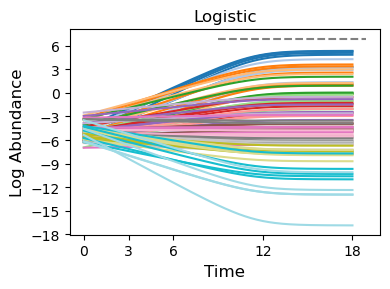

In [8]:
fig = futil.plot_log_abundance(params_true,params_time,model, K_N0,colors,figsize=figsize1,legend=False)

save_fig = False
if save_fig:
    plt.savefig(f'figs/fig1a_{model}.png', dpi=300, bbox_inches='tight', transparent=False)

In [9]:
#stop

### Generate reads from a multinomial distribution

Seed is: 9575438959115982149
total reads:
 [10061, 9874, 9993, 9993, 10106]
variant reads:
 [[  24  179  542 1232 1359]
 [  69  319  780 1509 1683]
 [  69  363  983 1903 2049]
 [ 113  530 1233 2132 2109]
 [  26  112  228  282  224]
 [ 111  372  639  768  776]
 [  36  130  236  248  265]
 [  60  187  291  214  174]
 [  28   69   63   41   26]
 [  17   54   69   33   21]
 [ 109  230  253  150  130]
 [  22   45   54   36   35]
 [ 396  838  879  423  387]
 [ 328  675  699  355  267]
 [  71  105  127   36   32]
 [  16   28   24    5    8]
 [ 617  960  754  216  221]
 [  29   41   19   13    5]
 [ 113  184  132   47   32]
 [ 352  541  466  129  114]
 [  25   55   48   10    8]
 [  42   68   50   16   13]
 [ 342  512  354   83   87]
 [  63   77   44    7   13]
 [ 177  235  132   27   26]
 [  17    9   12    3    1]
 [  53   79   53    9    5]
 [  56   68   32    5    2]
 [  54   59   31    4    4]
 [  23   22   14    0    1]
 [ 130  121   68   10    5]
 [   8   21    7    1    1]
 [  83   82 

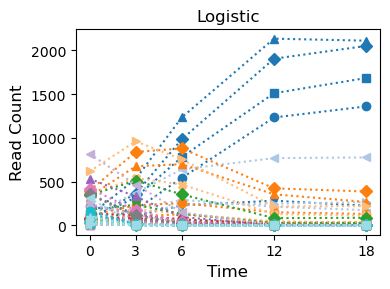

In [10]:
# calculate fractions
ys_true = futil.dynamics_selected_times(model,K_N0,times_fine,selected_indices,growth_rates_true,log_abundances_true)
fracs_true = torch.softmax(ys_true,dim=0)

# Mean value of total reads per time point
if K <= 100:
    lambda_ = 100*K
else:
    lambda_ = 300*K

seed = torch.seed()      # whatever PyTorch just pulled from /dev/urandom
#seed = 668516413311860819
seed = 9575438959115982149
print("Seed is:", seed)
torch.manual_seed(seed)

# Sample total reads per timepoint from Poisson
reads_tot = torch.poisson(torch.full((T,), lambda_, dtype=torch.float32))

# Initialize reads tensor
reads = torch.zeros((K, T), dtype=torch.float32)
# Sample Multinomial reads for each time point
for t in range(T):
    if reads_tot[t] > 0:
        # Multinomial expects probabilities to sum to 1 and counts as int
        reads[:, t] = torch.multinomial(fracs_true[:, t], int(reads_tot[t].item()), replacement=True).bincount(minlength=K)
    else:
        reads[:, t] = 0  # zero reads

# print generated counts
print("total reads:\n", reads_tot.int().tolist())
print("variant reads:\n", reads.int().numpy())

fig = futil.plot_read_counts(reads,times,model,colors,markers,figsize=figsize1,legend=False)

save_fig = False
if save_fig:
    plt.savefig(f'figs/K{K}_{model}_counts.png', dpi=300, bbox_inches='tight', transparent=True)

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 4, 5, 5, 3, 5, 4, 4, 5, 4, 5, 3, 3,
        3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3,
        3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3,
        2, 2, 2, 2])
[2 3 4 5] [13 37 11 39] 100
tensor(True)


/var/folders/11/tdzfd7bj5qgbln12gj6mnzxc0000gs/T/ipykernel_36185/2400979937.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plt.xticks(np.arange(oks.min(), oks.max() + 1, 1))


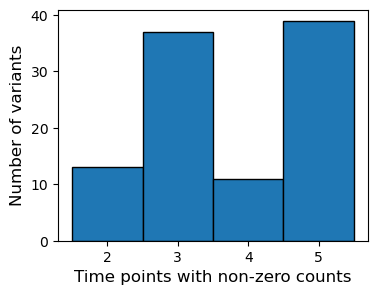

In [11]:
# Count non-zeros per row
nonzero_counts = torch.count_nonzero(reads, dim=1)

print(nonzero_counts)  
# tensor([2, 1, 2])

# Plot histogram
# Convert to NumPy for matplotlib
oks = nonzero_counts

values, counts = np.unique(oks, return_counts=True)
print(values,counts,counts.sum())

plt.figure(figsize=(4, 3)) 

plt.bar(values, counts, width=1, align="center", edgecolor="black")

# Force integer ticks
plt.xticks(np.arange(oks.min(), oks.max() + 1, 1))

plt.xlabel("Time points with non-zero counts",fontsize=12)
plt.ylabel("Number of variants",fontsize=12)

# Check condition
ok = (nonzero_counts >= 2).all()
print(ok)  

if not ok:
    stop
else:
    plt.savefig(f'figs/figS6a_K{K}_{model}.pdf', bbox_inches='tight')

plt.show()

In [12]:
#stop

## Empirical

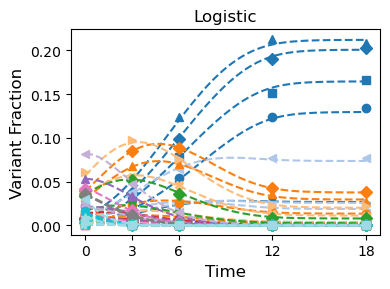

In [ ]:
fig = futil.plot_empirical(reads,params_true,params_time,model,K_N0,
                           colors,markers,figsize=figsize1,legend=False)

save_fig = False
if save_fig:
    plt.savefig(f'figs/nw_{model}_fML.pdf', bbox_inches='tight')

# Maximum Likelihood - Automatic differentiation

### Check if log likelihood function works with both shapes [K] and [K,M]

In [14]:
noises = [False,True]

for noise in noises:
    if noise:
        M = 8
        eps = torch.randn(K,M)
        sigmas = 0.03*torch.ones(K,) # K x 1
        lams = growth_rates_true[:,None] + sigmas[:,None]*eps
        dels = log_abundances_true[:,None] + sigmas[:,None]*eps
    else:
        lams = growth_rates_true
        dels = log_abundances_true
        
    ll = futil.calc_loglikelihood(model,K_N0,reads, times_fine, selected_indices, lams, dels)
    print("loglike:",ll.shape)

loglike: torch.Size([])
loglike: torch.Size([])


In [15]:
lr = 0.01
tol_loss = 1e-4
tol_vals = 1e-4
num_iterations=8000

growth_rates_ML, log_abundances_ML, history_ML = futil.optimize_LogLike(reads, params_time, model, K_N0,  
                                         lr=lr,tol=(tol_loss,tol_vals), num_iterations=num_iterations)
params_ML = [growth_rates_ML,log_abundances_ML]

Initial Params : lams = [0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100000, 0.100

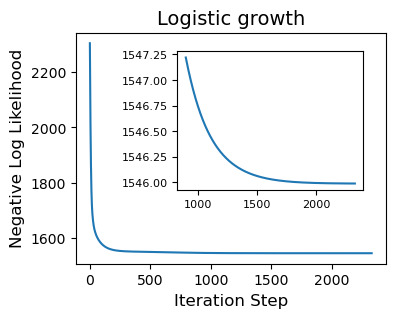

In [16]:
inset_start = 900

fig = futil.plot_History(history_ML,model,inset_start,figsize=figsize1)
save_fig = True
if save_fig:
    plt.savefig(f'figs/figS6b_K{K}_{model}.pdf', bbox_inches='tight')

In [17]:
print("True:")
#if model == 'exponential':
print(growth_rates_true-growth_rates_true.mean())
#else:
print(growth_rates_true)
print("ML:")
print(growth_rates_ML)
#
if model == 'gompertz':
    print(DIV_GOMP*growth_rates_ML)
print("\n")
print(log_abundances_true-log_abundances_true.mean())
print(log_abundances_ML-log_abundances_ML.mean())

True:
tensor([ 0.789,  0.759,  0.749,  0.725,  0.642,  0.640,  0.626,  0.552,  0.501,
         0.494,  0.483,  0.480,  0.458,  0.458,  0.402,  0.396,  0.370,  0.369,
         0.368,  0.360,  0.353,  0.336,  0.329,  0.296,  0.293,  0.281,  0.273,
         0.230,  0.216,  0.203,  0.184,  0.180,  0.172,  0.166,  0.160,  0.157,
         0.126,  0.100,  0.072,  0.071,  0.063,  0.062,  0.049,  0.041,  0.036,
         0.029, -0.031, -0.032, -0.035, -0.035, -0.040, -0.057, -0.075, -0.079,
        -0.079, -0.086, -0.088, -0.095, -0.096, -0.101, -0.101, -0.114, -0.118,
        -0.123, -0.139, -0.142, -0.143, -0.146, -0.147, -0.151, -0.164, -0.168,
        -0.192, -0.200, -0.218, -0.234, -0.244, -0.250, -0.269, -0.270, -0.280,
        -0.294, -0.301, -0.351, -0.368, -0.368, -0.394, -0.395, -0.398, -0.415,
        -0.458, -0.532, -0.611, -0.621, -0.634, -0.731, -0.742, -0.746, -0.834,
        -1.164])
tensor([ 9.360e-01,  9.063e-01,  8.966e-01,  8.725e-01,  7.890e-01,  7.875e-01,
         7.731e-0

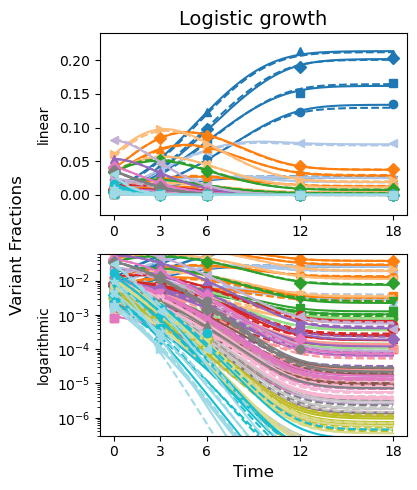

In [ ]:
fig = futil.plot_fractions(reads,params_true,params_ML,['True','ML Time'],params_time,
                                   model,K_N0,colors,markers,figsize=figsize2,ylabel=True,legend=False)
save_fig = False
if save_fig:
    plt.savefig(f'../figs/K{K}_{model}_ML.pdf', bbox_inches='tight')

In [19]:
#stop

# Variational Bayes - ALL points

In [20]:
num_steps = int(500)
lr = 0.03
M =  100  # Monte Carlo samples
F = 100  # Final averaging window

growth_rates_VB,sigmasL_VB,log_abundances_VB,sigmasD_VB,history_VB \
    = futil.optimize_ELBO(reads, params_time, model,K_N0, num_steps,lr,M,F, params_ML)

params_VB = [growth_rates_VB,log_abundances_VB]
sigmas_VB = [sigmasL_VB,sigmasD_VB]

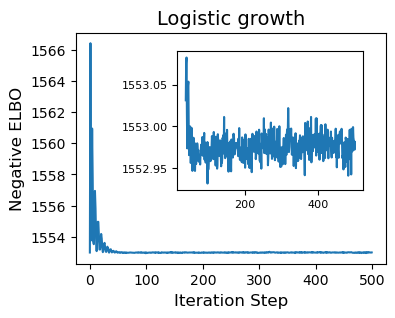

In [21]:
inset_start = 40
fig = futil.plot_History(history_VB,model,inset_start,figsize=figsize1,ylabel='Negative ELBO')

save_fig = True
if save_fig:
    plt.savefig(f'figs/figS6c_K{K}_{model}.pdf', bbox_inches='tight')

In [22]:
print(growth_rates_VB)
print(sigmasL_VB,"\n")
print(log_abundances_VB)
print(sigmasD_VB)

tensor([ 0.922,  0.880,  0.886,  0.851,  0.780,  0.773,  0.766,  0.688,  0.600,
         0.614,  0.618,  0.645,  0.594,  0.587,  0.537,  0.511,  0.499,  0.468,
         0.494,  0.500,  0.501,  0.493,  0.466,  0.419,  0.417,  0.402,  0.422,
         0.351,  0.360,  0.322,  0.340,  0.396,  0.284,  0.262,  0.324,  0.216,
         0.273,  0.290,  0.204,  0.042,  0.183,  0.232,  0.178,  0.173,  0.114,
         0.164,  0.139, -0.032,  0.075,  0.108,  0.189,  0.049,  0.106,  0.070,
         0.036,  0.046,  0.053, -0.075, -0.010,  0.005, -0.118,  0.091,  0.045,
         0.027,  0.035, -0.009, -0.109, -0.028, -0.001, -0.022, -0.021, -0.132,
        -0.047, -0.002, -0.137, -0.112, -0.224, -0.222, -0.310, -0.071, -0.179,
        -0.108, -0.157, -0.143, -0.389, -0.420, -0.315, -0.310, -0.403, -0.218,
        -0.379, -0.316, -0.731, -0.472, -0.487, -0.693, -0.777, -0.863, -1.046,
        -0.642])
tensor([0.002, 0.002, 0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.010, 0.010,
        0.005, 0.010, 0.0

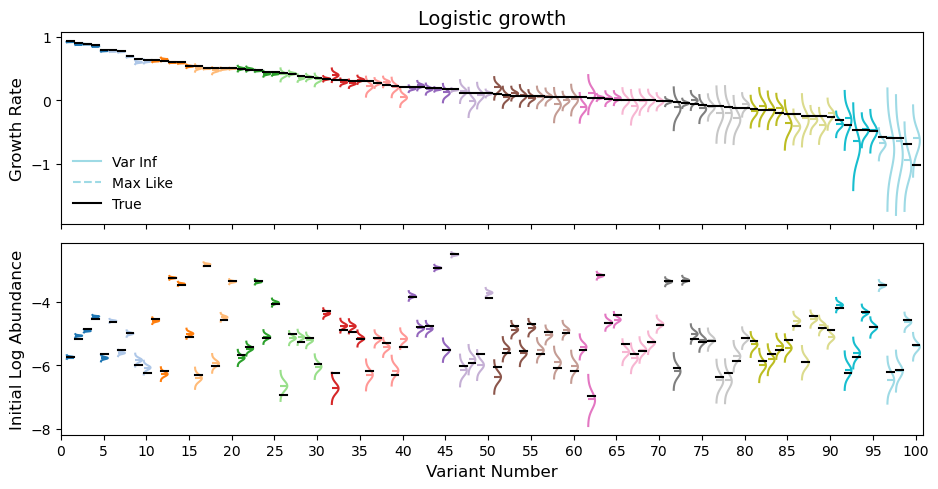

In [23]:
fig = futil.plot_Gaussians(params_true,params_ML,params_VB,sigmas_VB,model,
                           colors,figsize=figsizeH,ML=True)

save_fig = True
if save_fig:
    plt.savefig(f'figs/fig7a_K{K}_{model}.pdf', bbox_inches='tight')

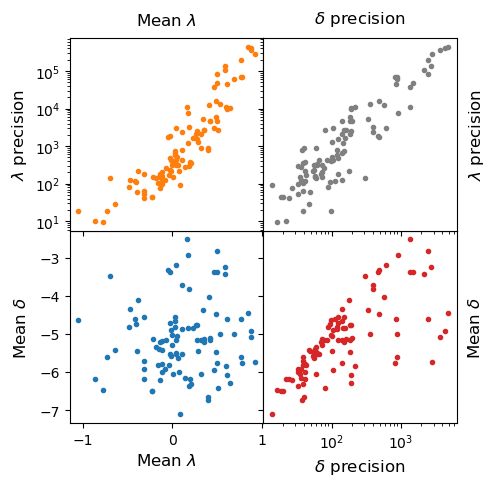

In [ ]:
# offsets in figure coordinates
x_off = 0.02
y_off = 0.02

fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(2, 2, wspace=0.0, hspace=0.0)

# Bottom-left
ax1 = plt.subplot(gs[1, 0])
ax1.plot(params_VB[0], params_VB[1], '.', color='C0')
#ax1.set_yscale("log")
ax1.set_xlabel(r'Mean $\lambda$',fontsize=12)
ax1.set_ylabel(r'Mean $\delta$',fontsize=12)

# Top-left
ax = plt.subplot(gs[0, 0])
ax.plot(params_VB[0], 1/sigmas_VB[0]**2, '.', color='C1')
ax.set_yscale("log")
ax.set_xlabel('')
ax.set_ylabel(r'$\lambda$ precision',fontsize=12)
# hide bottom tick labels (since this is the top row)
ax.tick_params(labelbottom=False)

# add top x-label
top_ax = ax
bbox = top_ax.get_position()
x_center = 0.5 * (bbox.x0 + bbox.x1)
y = bbox.y1 + y_off
fig.text(x_center, y, r'Mean $\lambda$', ha="center", va="bottom",fontsize=12)

fig.align_ylabels([ax1, ax])

# Bottom-right
ax = plt.subplot(gs[1, 1])
ax.plot(1/sigmas_VB[1]**2, params_VB[1], '.', color='C3')
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel(r'$\delta$ precision',fontsize=12)
ax.set_ylabel('')
# hide left tick labels (since this is the right column)
ax.tick_params(labelleft=False)

# add right y-label
right_ax = ax
bbox = right_ax.get_position()
x = bbox.x1 + x_off
row_bbox = ax1.get_position()
y_center = 0.5 * (row_bbox.y0 + row_bbox.y1)
fig.text(x, y_center, r'Mean $\delta$', rotation=90, va="center", ha="left",fontsize=12)

# Top-right
ax = plt.subplot(gs[0, 1])
ax.plot(1/sigmas_VB[1]**2, 1/sigmas_VB[0]**2, '.', color='gray')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelleft=False, labelbottom=False)  # inner ticks off

# add top x-label
bbox = ax.get_position()
x_center = 0.5 * (bbox.x0 + bbox.x1)
y = bbox.y1 + y_off
fig.text(x_center, y, r'$\delta$ precision', ha="center", va="bottom",fontsize=12)

# add right y-label
bbox = ax.get_position()
x = bbox.x1 + x_off
row_bbox = axes_pos = ax.get_position()
y_center = 0.5 * (row_bbox.y0 + row_bbox.y1)
fig.text(x, y_center, r'$\lambda$ precision', rotation=90,
         va="center", ha="left",fontsize=12)

save_fig = True
if save_fig:
    plt.savefig(f'figs/fig7c_K{K}_{model}.pdf', bbox_inches='tight')

plt.show()

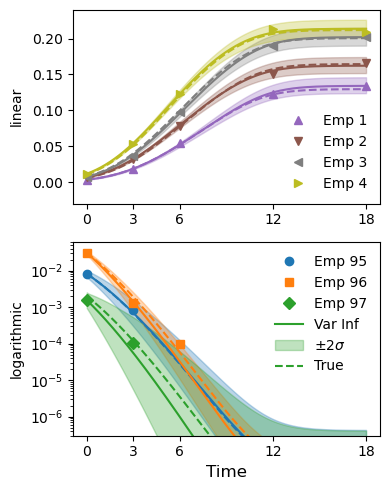

In [ ]:
if K < 500:
    fig = futil.plot_fractions_many(reads,params_true,params_VB,['True','Var Inf'],params_time,model,K_N0,
                            colors,markers,figsize=figsize2,ylabel=False,#legend=False,title='Variant Fractions',
                            sigmas=sigmas_VB,Mtrj=5000)
    save_fig = True
    if save_fig:
        plt.savefig(f'figs/fig7b_K{K}_{model}.pdf', bbox_inches='tight')